<a href="https://colab.research.google.com/github/Halilibrahim-Guc/Time_Series_Prediction_with_Dummy_Course_Enrollment_Data_Set/blob/main/Dummy_Prediction_with_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.preprocessing import OrdinalEncoder

In [5]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv('/content/DUMMY VERİ SETİ  (Tamamlanmış) - Veri Seti Taslağı.csv')
df.head(601)

,Ders Kodu\n\nCourse Code,Ders Adı\n\nCourse Name,Dönem\n\nTerm,Yıl\n\nYear,Kalan Öğrenci Sayısı\n\nFail,Geçen Öğrenci Sayısı\n\nPass,Ön Koşul Ders(ler)ini Geçen Öğrenci Sayısı\n\nPrerequisite Pass,Hazırlık Okulunu Geçip Derse Kayıt Olabilecek Öğrenci Sayısı\n\nPrep School Pass,Önceki Notunu Yükseltmek için Dersi Alan Öğrenci Sayısı\n\nRaise Grades,Not Ortalamasını Yükseltmek için Dersi Alan Öğrenci Sayısı\n\nIncrease GPA,Dersi Alan Yan / Çift Anadal Öğrencilerin Sayısı\n\nMinor / Double Major,Ders Kayıtlı Öğrenci Sayısı\n\nEnrolled Students,Gelecek Dönem Dersi Alacak Öğrenci Sayısı Tahmini\n\nFuture Enroll
0,CMPE114,Computer Programming II,Fall,2003,30,96,100,0,6,10,1,126,NaN
1,CMPE114,Computer Programming II,Spring,2004,40,97,95,0,8,9,1,137,NaN
2,CMPE114,Computer Programming II,Summer,2004,0,0,0,0,0,0,0,0,NaN
3,CMPE114,Computer Programming II,Fall,2004,29,93,97,0,8,9,1,122,NaN
4,CMPE114,Computer Programming II,Spring,2005,27,96,95,0,8,9,0,123,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,ISE 261,Business and e-Commerce,Spring,2022,0,0,0,0,0,0,0,0,NaN
596,ISE 261,Business and e-Commerce,Summer,2022,0,0,0,0,0,0,0,0,NaN
597,ISE 261,Business and e-Commerce,Fall,2022,8,51,0,2,3,1,2,59,NaN
598,ISE 261,Business and e-Commerce,Spring,2023,0,0,0,0,0,0,0,0,NaN


In [6]:
# Drop the empty column and rename the target column
df= df.drop(labels="Gelecek Dönem Dersi Alacak Öğrenci Sayısı Tahmini\n\nFuture Enroll",axis=1)
df.rename(columns = {'Ders Kayıtlı Öğrenci Sayısı\n\nEnrolled Students':'Target'}, inplace = True)

In [12]:
# Encode nominal categories and Renaming columns because of "Wrong size of feature_names" error.
enc = OrdinalEncoder()
df['Ders Kodu\n\nCourse Code'] = enc.fit_transform(df[["Ders Kodu\n\nCourse Code"]])
df['Ders Adı\n\nCourse Name'] = enc.fit_transform(df[["Ders Adı\n\nCourse Name"]])
df['Dönem\n\nTerm'] = enc.fit_transform(df[["Dönem\n\nTerm"]])

df.rename(columns = {'Ders Kodu\n\nCourse Code':'Ders Kodu'}, inplace = True)
df.rename(columns = {'Ders Adı\n\nCourse Name':'Ders Adı'}, inplace = True)
df.rename(columns = {'Dönem\n\nTerm':'Dönem'}, inplace = True)
df.rename(columns = {'Yıl\n\nYear':'Yıl'}, inplace = True)
df.rename(columns = {'Kalan Öğrenci Sayısı\n\nFail':'Kalan Öğrenci'}, inplace = True)
df.rename(columns = {'Geçen Öğrenci Sayısı\n\nPass':'Geçen Öğrenci'}, inplace = True)
df.rename(columns = {'Ön Koşul Ders(ler)ini Geçen Öğrenci Sayısı\n\nPrerequisite Pass':'Ön Koşul Geçen'}, inplace = True)
df.rename(columns = {'Hazırlık Okulunu Geçip Derse Kayıt Olabilecek Öğrenci Sayısı\n\nPrep School Pass':'Hazırlık Geçip Gelebilecek'}, inplace = True)
df.rename(columns = {'Önceki Notunu Yükseltmek için Dersi Alan Öğrenci Sayısı\n\nRaise Grades':'Önceki Notunu Yükseltmek için Alan'}, inplace = True)
df.rename(columns = {'Not Ortalamasını Yükseltmek için Dersi Alan Öğrenci Sayısı\n\nIncrease GPA':'GPA Nedeniyle Alan'}, inplace = True)
df.rename(columns = {'Dersi Alan Yan / Çift Anadal Öğrencilerin Sayısı\n\nMinor / Double Major':'Yan / Çift Anadal Öğrencisi'}, inplace = True)

df.head(601)

,Ders Kodu,Ders Adı,Dönem,Yıl,Kalan Öğrenci,Geçen Öğrenci,Ön Koşul Geçen,Hazırlık Geçip Gelebilecek,Önceki Notunu Yükseltmek için Alan,GPA Nedeniyle Alan,Yan / Çift Anadal Öğrencisi,Target
0,3.0,2.0,0.0,2003,30,96,100,0,6,10,1,126
1,3.0,2.0,1.0,2004,40,97,95,0,8,9,1,137
2,3.0,2.0,2.0,2004,0,0,0,0,0,0,0,0
3,3.0,2.0,0.0,2004,29,93,97,0,8,9,1,122
4,3.0,2.0,1.0,2005,27,96,95,0,8,9,0,123
...,...,...,...,...,...,...,...,...,...,...,...,...
595,5.0,1.0,1.0,2022,0,0,0,0,0,0,0,0
596,5.0,1.0,2.0,2022,0,0,0,0,0,0,0,0
597,5.0,1.0,0.0,2022,8,51,0,2,3,1,2,59
598,5.0,1.0,1.0,2023,0,0,0,0,0,0,0,0


In [13]:
# Extract the features and target variable from the DataFrame
X = df.iloc[:, :-1]
y = df[['Target']]
print(X.shape, y.shape)

(600, 11) (600, 1)


In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Define the LightGBM model
lgb_model = lgb.LGBMRegressor(
    task = 'predict',
    application = 'regression',
    objective = 'root_mean_squared_error',
    boosting_type="gbdt",
    #num_iterations = 2500,
    learning_rate = 0.05,
    num_leaves=15,
    tree_learner='feature',
    max_depth =10,
    reg_sqrt='True',
    metric ='rmse',
    random_state=42)

lgb_model.fit(X_train,y_train) 

LGBMRegressor(application='regression', learning_rate=0.05, max_depth=10,
              metric='rmse', num_leaves=15, objective='root_mean_squared_error',
              random_state=42, reg_sqrt='True', task='predict',
              tree_learner='feature')

In [16]:
# Evaluate the performance of the model on the test data using RMSE
y_pred = lgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.3f' % rmse)

RMSE: 3.478


In [21]:
# Calculate R-squared of regression model
R_square = r2_score(y_test, y_pred)
print('Coefficient of Determination', R_square)

Coefficient of Determination 0.99543690346354


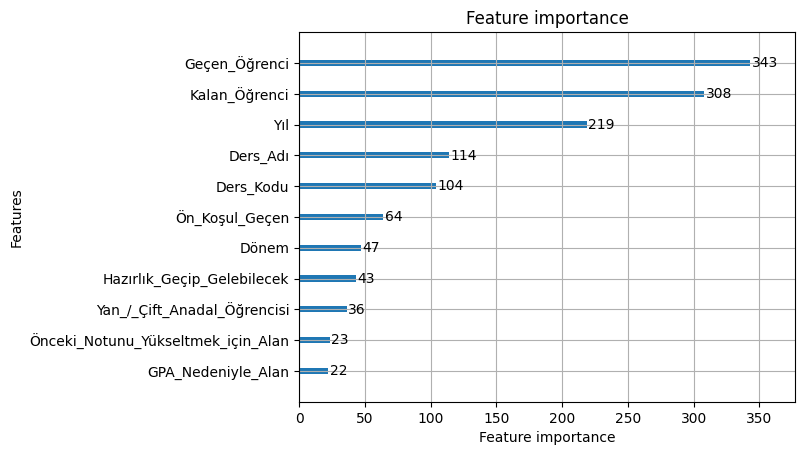

<Figure size 1600x1200 with 0 Axes>

In [17]:
# Show the feature importance
lgb.plot_importance(lgb_model)
plt.figure(figsize = (16, 12))
plt.show()

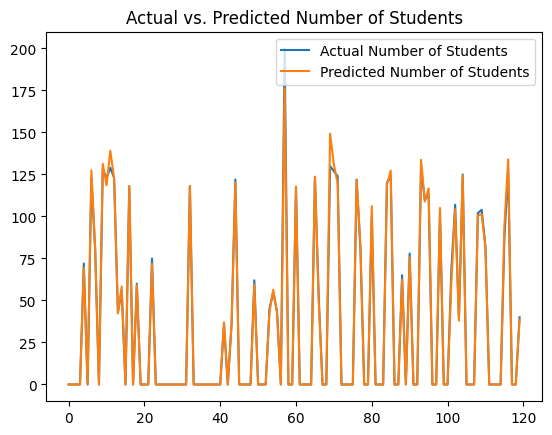

In [20]:
# Plot the predicted values against the actual values on a scatter plot
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Actual Number of Students")
plt.plot(x_ax, y_pred, label="Predicted Number of Students")
plt.title('Actual vs. Predicted Number of Students')
plt.legend()
plt.show()